In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

from sklearn.metrics import confusion_matrix, classification_report

from notifyme import notifyme

In [2]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [3]:
dataset_path = 'datasets/B-Disease_Grading'
data_path = '1-Original_Images'
label_path = '2-Groundtruths'

train_data_path = os.path.join(dataset_path, data_path, 'a-Train_Set')
test_data_path = os.path.join(dataset_path, data_path, 'b-Test_Set')
train_labels = os.path.join(dataset_path, label_path, 'a-Train_Labels.csv')
test_labels = os.path.join(dataset_path, label_path, 'b-Test_Labels.csv')

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)   # [B, 3, 448, 448]
        self.pool1 = nn.MaxPool2d(2, 2)                           # [B, 16, 224, 224]

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # [B, 16, 224, 224]
        self.pool2 = nn.MaxPool2d(4, 4)                           # [B, 32, 56, 56]

        self.fc1 = nn.Linear(32 * 64 * 96, 512)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [5]:
class IDRiDDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['Image name'] + '.jpg'
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path)#.convert('RGB')

        retinopathy = int(self.data.iloc[idx]['Retinopathy grade'])
        edema = int(self.data.iloc[idx]['Risk of macular edema '])

        if self.transform:
            image = self.transform(image)

        return image, {'retinopathy': retinopathy, 'edema': edema}

## Training

In [6]:
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

    mean = 0.0
    std = 0.0
    nb_samples = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0)  # batch size (32)
        images = images.view(batch_samples, images.size(1), -1)  # [B, C, H*W]
        
        mean += images.mean(2).sum(0)  # sum of channel means
        std += images.std(2).sum(0)    # sum of channel stds
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples

    return mean.numpy(), std.numpy()

transform_mean_std = transforms.Compose([
    transforms.Resize(512),
    transforms.CenterCrop(448),
    transforms.ToTensor()
])

dataset_mean_std = IDRiDDataset(
    img_dir=train_data_path,
    csv_file=train_labels,
    transform=transform_mean_std
)

mean, std = compute_mean_std(dataset_mean_std)
print(f"Mean: {mean}\nStd: {std}")

100%|██████████| 13/13 [00:12<00:00,  1.07it/s]

Mean: [0.64398366 0.31709325 0.10248035]
Std: [0.11275874 0.08133845 0.03794106]


In [7]:
train_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.RandomResizedCrop(448, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_test_transform = transforms.Compose([
    transforms.Resize(512),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_val_dataset = IDRiDDataset(
    img_dir=train_data_path,
    csv_file=train_labels
)

train_dataset, val_dataset = random_split(train_val_dataset, [0.8, 0.2])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [8]:
num_classes = len(pd.read_csv(train_labels)['Retinopathy grade'].unique())
cnn_model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.00025, weight_decay=1e-4)

In [9]:
def train(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # === Training Phase ===
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            targets = labels['retinopathy'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        avg_train_loss = train_loss / train_total
        train_acc = 100 * train_correct / train_total

        # === Validation Phase ===
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                targets = labels['retinopathy'].to(device)

                outputs = model(images)
                loss = criterion(outputs, targets)

                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()

        avg_val_loss = val_loss / val_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        # Print metrics after each epoch
        epochs_length = len(str(epochs))
        print(f"Epoch {epoch+1:0{epochs_length}}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    return train_losses, train_accuracies, val_losses, val_accuracies

In [10]:
train_losses, train_accuracies, val_losses, val_accuracies = train(cnn_model, train_loader, val_loader,
                                                                   optimizer, criterion, device, epochs=25)

notifyme("Training completed", "The CNN model has been trained successfully.")

Epoch 01/25 | Train Loss: 7.8939 | Train Acc: 27.49% | Val Loss: 1.7637 | Val Acc: 45.12%
Epoch 02/25 | Train Loss: 2.6209 | Train Acc: 33.84% | Val Loss: 1.3009 | Val Acc: 54.88%
Epoch 03/25 | Train Loss: 1.4236 | Train Acc: 47.13% | Val Loss: 1.1352 | Val Acc: 57.32%
Epoch 04/25 | Train Loss: 1.1890 | Train Acc: 53.47% | Val Loss: 1.1435 | Val Acc: 50.00%
Epoch 05/25 | Train Loss: 1.1400 | Train Acc: 54.68% | Val Loss: 1.1462 | Val Acc: 54.88%
Epoch 06/25 | Train Loss: 1.0439 | Train Acc: 58.91% | Val Loss: 1.1089 | Val Acc: 58.54%
Epoch 07/25 | Train Loss: 0.9782 | Train Acc: 60.12% | Val Loss: 1.1158 | Val Acc: 56.10%
Epoch 08/25 | Train Loss: 0.9348 | Train Acc: 62.24% | Val Loss: 1.1755 | Val Acc: 50.00%
Epoch 09/25 | Train Loss: 0.8540 | Train Acc: 67.67% | Val Loss: 1.1557 | Val Acc: 50.00%
Epoch 10/25 | Train Loss: 0.7881 | Train Acc: 67.98% | Val Loss: 1.1801 | Val Acc: 58.54%
Epoch 11/25 | Train Loss: 0.7107 | Train Acc: 71.60% | Val Loss: 1.3528 | Val Acc: 48.78%
Epoch 12/2

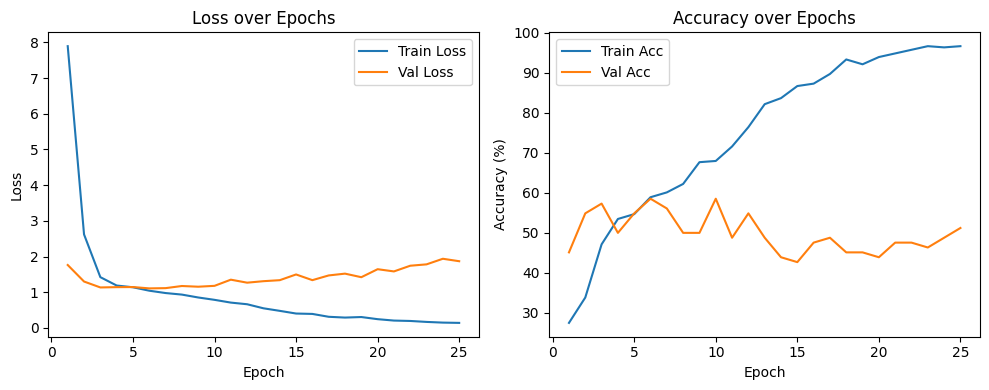

In [11]:
epochs_range = range(1, len(train_losses) + 1)

# Loss plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Testing

In [12]:
test_dataset = IDRiDDataset(
    img_dir=test_data_path,
    csv_file=test_labels,
    transform=val_test_transform
)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
test_pred_probs = []
test_pred_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels['retinopathy'].to(device)
        outputs = cnn_model(images)
        pred_probs = F.softmax(outputs, dim=1)
        test_pred_probs.extend(pred_probs.cpu().numpy())
        pred_label = torch.argmax(outputs, dim=1)
        test_pred_labels.extend(pred_label.cpu().numpy())

notifyme("Testing completed", "The CNN model has been tested successfully.")

              precision    recall  f1-score   support

           0       0.55      0.50      0.52        34
           1       0.00      0.00      0.00         5
           2       0.43      0.38      0.40        32
           3       0.27      0.42      0.33        19
           4       0.08      0.08      0.08        13

    accuracy                           0.37       103
   macro avg       0.26      0.27      0.27       103
weighted avg       0.37      0.37      0.37       103

[[17  1  7  6  3]
 [ 1  0  2  1  1]
 [ 6  0 12 10  4]
 [ 3  0  4  8  4]
 [ 4  0  3  5  1]]


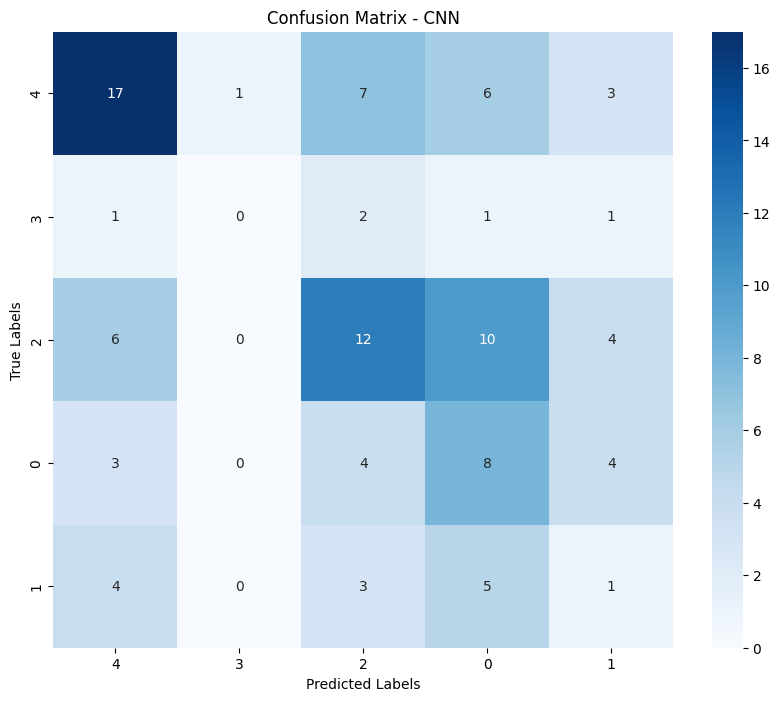

In [14]:
test_labels = pd.read_csv(test_labels)['Retinopathy grade']
classes = test_labels.unique()

report = classification_report(test_labels, test_pred_labels)
print(report)

cm = confusion_matrix(test_labels, test_pred_labels)
print(cm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, 
            yticklabels=classes)
plt.title("Confusion Matrix - CNN")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 🔍 Model Performance Analysis

### Summary

The model achieves an overall accuracy of **37%** and a **macro-averaged F1-score of 0.27**. The class-wise performance reveals a significant variation in how well the model handles different categories:

- **Class 0** shows the highest precision (0.55) and recall (0.50), indicating relatively strong performance in identifying this category.
- **Class 1** has zero precision and recall, suggesting it is not being correctly classified at all.
- **Class 2** achieves moderate scores with a precision of 0.43 and recall of 0.38.
- **Class 3** has slightly lower precision (0.27) but a recall of 0.42, indicating the model is more likely to identify class 3 but with some false positives.
- **Class 4** shows very low scores across all metrics, with an F1-score of just 0.08.

### Confusion Matrix Insights

The confusion matrix highlights several important trends:

- Class 0 is most often confused with classes 2, 3, and 4.
- Class 2 is commonly misclassified as class 3.
- Class 3 and 4 exhibit substantial misclassification into each other and into class 2.
- Class 1 is misclassified broadly across other categories, with no strong prediction pattern.

### Recommendations

1. **Address Class Imbalance**:
   - Introduce class weighting in the loss function to emphasize underrepresented or underperforming classes.
   - Consider oversampling minority classes or applying targeted data augmentation to enrich their representation.

2. **Model Architecture Improvements**:
   - Upgrade from a basic CNN to a pretrained architecture (e.g., ResNet, EfficientNet) to improve feature extraction and generalization.

3. **Data Preprocessing**:
   - Review image normalization and augmentation strategies to ensure consistency and avoid overfitting on more common patterns.

4. **Evaluation Strategy**:
   - Complement the confusion matrix with sample-level error inspection.
   - Use interpretability tools (e.g., Grad-CAM) to analyze what the model focuses on in each class.

### Conclusion

The current model captures class 0 well but underperforms on several other categories, especially class 1 and class 4. Enhancements in model architecture, data balancing, and error analysis are recommended to improve the overall performance and robustness.